# Libaries

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import get_dummies

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics      import auc
from sklearn.metrics      import roc_auc_score

# Importing data

In [219]:
# Importing data

camp = pd.read_csv('../Data/raw/campaigns.csv', sep=';')
donors = pd.read_csv('../Data/raw/donors.csv', sep=',')
gifts = pd.read_csv('../Data/raw/gifts.csv', sep=',')
sc6 = pd.read_csv('../Data/raw/selection campaign 6169.csv')
sc7 = pd.read_csv('../Data/raw/selection campaign 7244.csv')

# References

In [220]:
rd1 = pd.to_datetime('2018-09-04') # date of 6169 campaign
rd2 = pd.to_datetime('2019-06-18') # date of 7244 campaign

# I/ Data description + Cleaning

## 1) Campaign

### General inspection

In [221]:
# Displaying the campaign table
camp.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [222]:
# Displaying information
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


### Missing values and outliers

In [223]:
# Convert date to datetime
camp['date'] = pd.to_datetime(camp['date'])
camp['campaignID'] = camp['campaignID'].astype(str)

C:\Users\Source\AppData\Local\Temp\ipykernel_30508\97374703.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  camp['date'] = pd.to_datetime(camp['date'])


In [224]:
# Convert the letterSent and cost per unit to a number
# To find outliers, we need to convert columns to integer before
camp['lettersSent'] = (
    camp['lettersSent']
        .astype(str)
        .str.replace(r'\D+', '', regex=True)
        .astype(int)
)

camp['CostUnit'] = (
    camp['CostUnit']
        .astype(str)
        .str.replace(r'[^0-9,.-]', '', regex=True)
        .str.replace(',', '.', regex=False)
        .astype(float)
)
camp.head()

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6873,0.17
1,154,2005-01-01,7656,0.30
2,180,2005-01-18,9933,0.20
3,433,2005-01-29,7448,0.59
4,476,2005-02-12,6605,0.51


In [225]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(camp.isna().sum())
print('---------------------------------')
print(f'The data shows {camp.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
campaignID     0
date           0
lettersSent    0
CostUnit       0
dtype: int64
---------------------------------
The data shows 0 missing values


In [226]:
# Finding outliers (using only the numerical columns)
num_cols = camp.select_dtypes(include=['float', 'int']).columns[-2:]

lower = camp[num_cols].quantile(0.01)
upper = camp[num_cols].quantile(0.99)

# printing the results
print(lower)
print(upper)

lettersSent    5243.66
CostUnit          0.02
Name: 0.01, dtype: float64
lettersSent    47746.96
CostUnit           0.61
Name: 0.99, dtype: float64


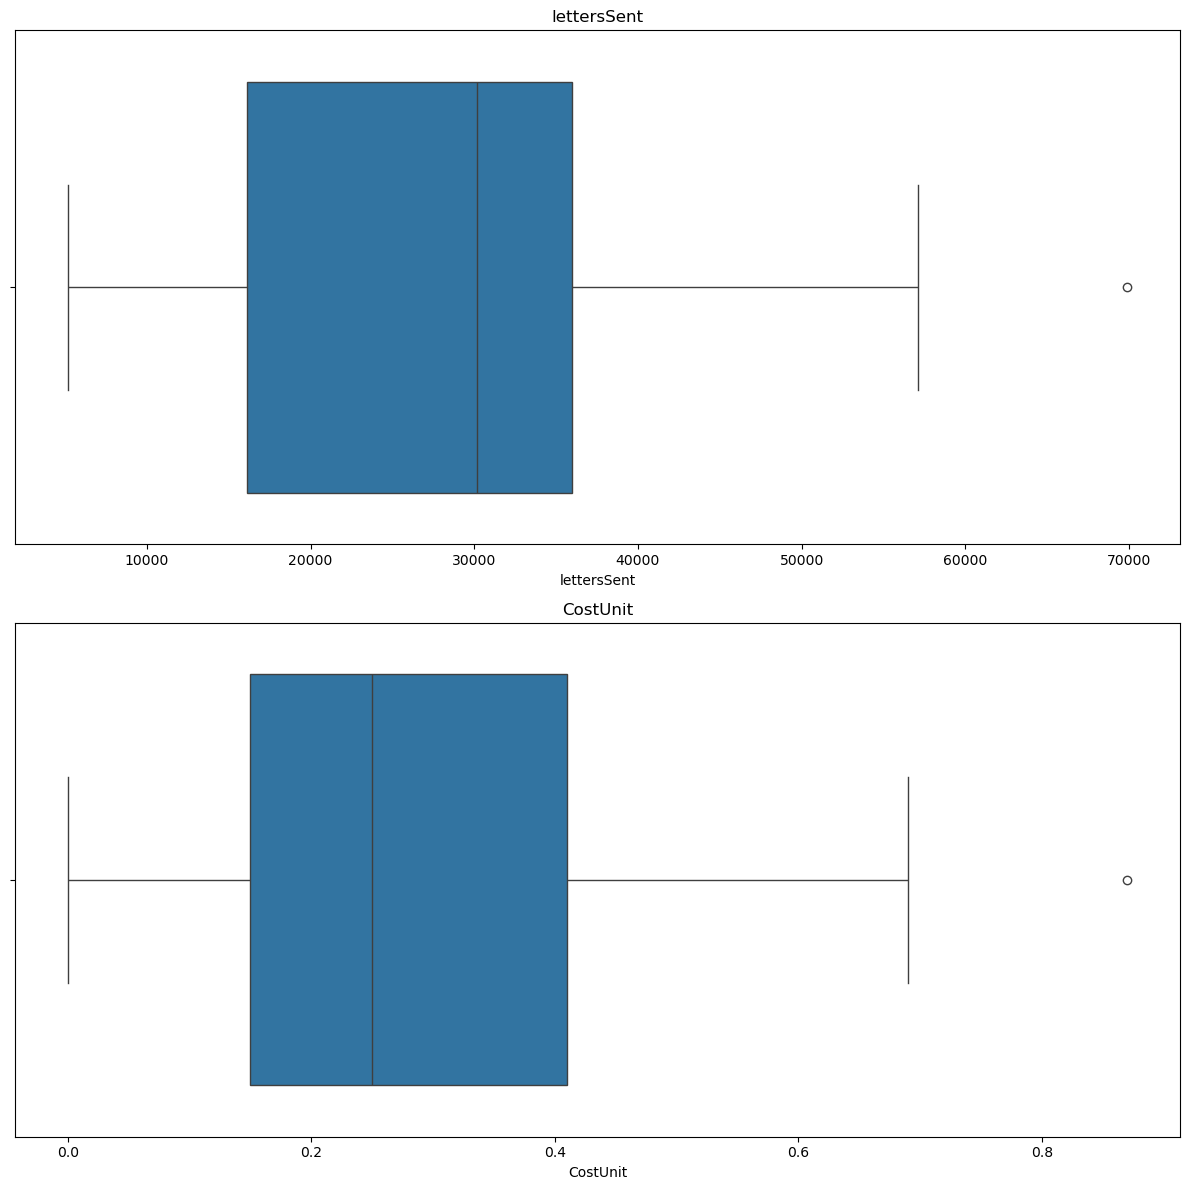

In [227]:
# Verifying outliers
# I would have checked only lettersSent and CostUnit
cols = camp.columns[-2:]

fig, ax = plt.subplots(nrows=len(cols), ncols=1, figsize=(12, 12))

for i, col in enumerate(cols):
    sns.boxplot(ax=ax[i], x=camp[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [228]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
camp = camp.copy()
camp[num_cols] = camp[num_cols].clip(lower=lower, upper=upper, axis=1)

In [229]:
# Verifying winsorization worked
for col in num_cols:
    print(col, 'min :', round(camp[col].min(),2))
    print(col, 'max :', round(camp[col].max(),2))

lettersSent min : 5243.66
lettersSent max : 47746.96
CostUnit min : 0.02
CostUnit max : 0.61


In [230]:
camp.head(2)

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6873.0,0.17
1,154,2005-01-01,7656.0,0.30


## 2) Donors

### General inspection

In [231]:
# Displaying the donors table
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967
1,D100002,2260.0,Antwerp,Flanders,M,NL,01/14/1952
2,D100003,1780.0,Flemish Brabant,Flanders,M,NL,12/23/1986
3,D100004,1020.0,Brussels,Brussels,F,FR,03/29/1952
4,D100005,1020.0,Brussels,Brussels,F,FR,06/25/1986


In [232]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   donorID      44691 non-null  object 
 1   zipcode      44689 non-null  float64
 2   province     44691 non-null  object 
 3   region       44691 non-null  object 
 4   gender       44659 non-null  object 
 5   language     44691 non-null  object 
 6   dateOfBirth  44691 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.4+ MB


### Missing values and outliers

In [233]:
# Convert date to datetime
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

In [234]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(donors.isna().sum())
print('---------------------------------')
print(f'The data shows {donors.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID         0
zipcode         2
province        0
region          0
gender         32
language        0
dateOfBirth     0
dtype: int64
---------------------------------
The data shows 34 missing values


In [235]:
# Handling missing values

# zipcode
donors = donors.dropna(subset=['zipcode']) # Remove but if the univariate analisis says that this variable is not usefull we have to bring back the null values since null values are only in this column. 

# gender
donors['gender'] = donors['gender'].fillna(value='missing') #I would create a new category called missing 

print(f'The data shows {donors.isna().sum().sum()} missing values now')

The data shows 0 missing values now


In [236]:
# Checking that there are indeed 44 689 different clients
donors['donorID'].nunique()

44689

Not necessary 

In [237]:
# Convert zipcode to string since is an "id"
donors['zipcode'] = donors['zipcode'].astype(str) 

In [238]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   donorID      44689 non-null  object        
 1   zipcode      44689 non-null  object        
 2   province     44689 non-null  object        
 3   region       44689 non-null  object        
 4   gender       44689 non-null  object        
 5   language     44689 non-null  object        
 6   dateOfBirth  44689 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 2.7+ MB


In [239]:
donors.head(2)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14


## 3) Gifts

### General inspection

In [240]:
# Displaying the gifts table
gifts.head(5)

,donorID,campaignID,amount,date
0,D100001,NaN,"12,39",23/03/2004
1,D100001,1577.0,"12,39",11/10/2007
2,D100001,1634.0,"6,69",28/12/2007
3,D100001,1778.0,"24,79",14/06/2008
4,D100001,1808.0,"7,44",09/07/2008


In [241]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   donorID     216594 non-null  object 
 1   campaignID  200957 non-null  float64
 2   amount      216594 non-null  object 
 3   date        216594 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.6+ MB


### Missing values and outliers

In [242]:
# Convert date to datetime
gifts['date'] = pd.to_datetime(gifts['date'])

# Be more specific
gifts = gifts.rename(columns={'date' : 'gift_date'})

C:\Users\Source\AppData\Local\Temp\ipykernel_30508\2177558126.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  gifts['date'] = pd.to_datetime(gifts['date'])


In [243]:
gifts[gifts['amount'].astype(str).str.len() > 7]

,donorID,campaignID,amount,gift_date
6360,D100778,1556.0,"16,432,000,000,000,000",2007-09-10
16715,D101892,NaN,"5,044,600,000,000,000",2000-11-22
28595,D103120,NaN,"12,895,999,999,999,900",2006-03-24
30550,D103291,850.0,"5,044,600,000,000,000",2005-10-15
33916,D103651,1933.0,"11,595,999,999,999,900",2008-12-04
35879,D103890,1755.0,"32,486,999,999,999,900",2008-05-12
49064,D105463,NaN,"48,333,999,999,999,900",2003-11-24
53730,D106008,NaN,"48,333,999,999,999,900",2006-05-04
56480,D106396,NaN,"48,333,999,999,999,900",2001-03-20
56483,D106396,NaN,"48,333,999,999,999,900",2002-05-31


In [244]:
#Important!! Here we are removing invalid numbers that doesn't make sense because of the amount and format (16 cuatrillions ) and there isn't a way to recover them. 

gifts['amount'] = pd.to_numeric(gifts['amount'].astype(str).str.replace(",",".").str[:-1], errors = 'coerce') #New null values in amount

In [245]:
gifts[gifts['amount'].astype(str).str.len() > 7]

,donorID,campaignID,amount,gift_date
141895,D120861,1917.0,2479000.0,2008-11-17
153012,D123168,NaN,4000000.0,2010-04-26


In [246]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(gifts.isna().sum())
print('---------------------------------')
print(f'The data shows {gifts.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID           0
campaignID    15637
amount           23
gift_date         0
dtype: int64
---------------------------------
The data shows 15660 missing values


In [247]:
# Handling missing values
gifts['campaignID'] = gifts['campaignID'].fillna(value= 'out')
# Missing values in campaignID mean that are donnations outside any other campaign. "The unique ID of the campaign (donation was made outside of a campaign if missing)."

#Create flag
gifts['outside_campaign'] = 0
gifts.loc[gifts['campaignID'] == 'out','outside_campaign'] = 1 #I think we can drop the column campaignId for our model. 

#Drop invalid values
gifts = gifts[gifts['amount'].isnull() == False]
print(f'There are {gifts.isna().sum().sum()} missing values now')

There are 0 missing values now


In [248]:
gifts.groupby('donorID')['outside_campaign'].sum().max()

228

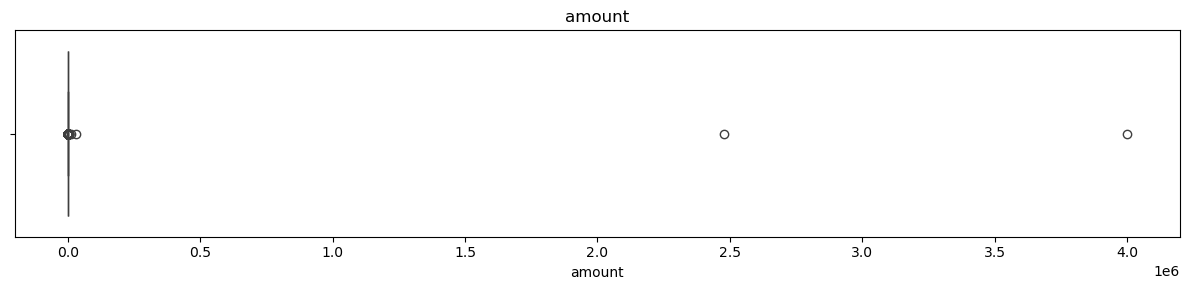

In [249]:
# Verifying outliers
gifts['campaignID'] = gifts['campaignID'].astype(str)
cols = ['amount']

fig, ax = plt.subplots(nrows=len(cols), ncols=1, figsize=(12, 3))

sns.boxplot(x=gifts['amount'], ax=ax)

ax.set_title('amount')



plt.tight_layout()
plt.show()

In [250]:
# Winsorizing the results
lower = gifts[cols].quantile(0.01)
upper = gifts[cols].quantile(0.99)

# printing the results
print(lower)
print(upper)

amount    2.0
Name: 0.01, dtype: float64
amount    123.9
Name: 0.99, dtype: float64


In [251]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
gifts = gifts.copy()
gifts[cols] = gifts[cols].clip(lower=lower, upper=upper, axis=1)

In [252]:

print(gifts['amount'].min())
print(gifts['amount'].max())

2.0
123.9


In [253]:
gifts.info()


<class 'pandas.core.frame.DataFrame'>
Index: 216571 entries, 0 to 216593
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   donorID           216571 non-null  object        
 1   campaignID        216571 non-null  object        
 2   amount            216571 non-null  float64       
 3   gift_date         216571 non-null  datetime64[ns]
 4   outside_campaign  216571 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 9.9+ MB


## 4) Selection campaign 6169

### General inspection

In [254]:
# Displaying the sc6 table
sc6.head()

,donorID
0,D100001
1,D100002
2,D100004
3,D100008
4,D100009


In [255]:
sc6.shape

(34888, 1)

### Missing values

In [256]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(sc6.isna().sum())
print('---------------------------------')
print(f'The data shows {sc6.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID    0
dtype: int64
---------------------------------
The data shows 0 missing values


## 5) selection campaign 7244

### General inspection

In [257]:
# Displaying the sc7 table
sc7.head()

,donorID
0,D100001
1,D100002
2,D100008
3,D100009
4,D100010


### Missing values

In [258]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(sc7.isna().sum())
print('---------------------------------')
print(f'The data shows {sc7.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID    0
dtype: int64
---------------------------------
The data shows 0 missing values


In [259]:
sc6.merge(gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')], how= 'left', on = 'donorID').groupby('donorID')['amount'].count()

donorID
D100001    0
D100002    1
D100004    0
D100008    0
D100009    0
          ..
D263382    0
D265584    0
D281770    0
D317880    0
D480980    0
Name: amount, Length: 34888, dtype: int64

# III/ Independent variable + basetable creation

In [260]:
temp = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].sum()

In [261]:
sc6.merge(temp, how = 'left',on= 'donorID')['amount'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 34888 entries, 0 to 34887
Series name: amount
Non-Null Count  Dtype  
--------------  -----  
11119 non-null  float64
dtypes: float64(1)
memory usage: 272.7 KB


Training

In [262]:
#Total donated

training_x = donors.copy()
training_x = sc6.merge(training_x, how= 'left', on = 'donorID')
temp = pd.DataFrame()

temp['total_donated'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].sum()

#quantity 
temp['num_donations'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].count()

#Total donated outside campaign
temp['donated_outs_camp'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['outside_campaign'] == 1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].sum()
temp['num_outs_camp'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['outside_campaign'] == 1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].count()

#Total donated inside campaign
temp['donated_ins_camp'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['outside_campaign'] == 0) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].sum()
temp['num_ins_camp'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['outside_campaign'] == 0) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].count()

#Max donated 
temp['max_donated'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].max()

#Last donated
temp['last_time_donated(days)'] = (rd1 - gifts[gifts['gift_date'] <= rd1].groupby('donorID')['gift_date'].max()).dt.days

#Total donated last year
temp['donated_last_year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-09-04')].groupby('donorID')['amount'].sum()
temp['count_last_year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-09-04')].groupby('donorID')['amount'].count()
temp['last_year_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-09-04')].groupby('donorID')['amount'].mean()

#Total donated last 3 years
temp['donated_last_3year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2015-09-04')].groupby('donorID')['amount'].sum()
temp['count_last_3year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2015-09-04')].groupby('donorID')['amount'].count()
temp['last_3year_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2015-09-04')].groupby('donorID')['amount'].mean()

#Total donated last month
temp['donated_last_month'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-08-04')].groupby('donorID')['amount'].sum()
temp['count_last_month'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-08-04')].groupby('donorID')['amount'].count()
temp['last_month_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-08-04')].groupby('donorID')['amount'].mean()

#Total donated last 3months
temp['donated_last_3months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-04')].groupby('donorID')['amount'].sum()
temp['count_last_3months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-04')].groupby('donorID')['amount'].count()
temp['last_month_3means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-04')].groupby('donorID')['amount'].mean()

#Total donated last 6months
temp['donated_last_6months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-03-04')].groupby('donorID')['amount'].sum()
temp['count_last_6months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-03-04')].groupby('donorID')['amount'].count()
temp['last_month_6means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-03-04')].groupby('donorID')['amount'].mean()

#Total donated last 9months
temp['donated_last_9months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-12-04')].groupby('donorID')['amount'].sum()
temp['count_last_9months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-12-04')].groupby('donorID')['amount'].count()
temp['last_month_9means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-12-04')].groupby('donorID')['amount'].mean()

#Ratios
temp['ratio_amount'] = (gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].sum() /
                            gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')]['amount'].sum())

temp['ratio_count_amount'] = (gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].count() /
                                gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')]['amount'].count())


#Merge
training_x = training_x.merge(temp, how = 'left', left_on= 'donorID', right_index= True)
training_x

,donorID,zipcode,province,region,gender,language,dateOfBirth,total_donated,num_donations,donated_outs_camp,...,count_last_3months,last_month_3means,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,20.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,0.000024
2,D100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D100008,1780.0,Flemish Brabant,Flanders,M,FR,1937-08-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100009,1020.0,Brussels,Brussels,M,FR,1932-01-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34883,D144686,2440.0,Antwerp,Flanders,F,NL,1964-09-28,50.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000045,0.000024
34884,D144687,4900.0,Liege,Wallonia,M,FR,1970-09-12,10.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000009,0.000024
34885,D144689,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,100.0,1.0,NaN,...,1.0,100.0,100.0,1.0,100.0,100.0,1.0,100.0,0.000089,0.000024
34886,D144690,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,40.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000036,0.000024


In [263]:
training_x.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   donorID                  34888 non-null  object        
 1   zipcode                  34872 non-null  object        
 2   province                 34872 non-null  object        
 3   region                   34872 non-null  object        
 4   gender                   34872 non-null  object        
 5   language                 34872 non-null  object        
 6   dateOfBirth              34872 non-null  datetime64[ns]
 7   total_donated            11119 non-null  float64       
 8   num_donations            11119 non-null  float64       
 9   donated_outs_camp        584 non-null    float64       
 10  num_outs_camp            584 non-null    float64       
 11  donated_ins_camp         10685 non-null  float64       
 12  num_ins_camp             10685 n

In [264]:
training_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   donorID                  34888 non-null  object        
 1   zipcode                  34872 non-null  object        
 2   province                 34872 non-null  object        
 3   region                   34872 non-null  object        
 4   gender                   34872 non-null  object        
 5   language                 34872 non-null  object        
 6   dateOfBirth              34872 non-null  datetime64[ns]
 7   total_donated            11119 non-null  float64       
 8   num_donations            11119 non-null  float64       
 9   donated_outs_camp        584 non-null    float64       
 10  num_outs_camp            584 non-null    float64       
 11  donated_ins_camp         10685 non-null  float64       
 12  num_ins_camp             10685 n

Validation

In [265]:
#Total donated

validation_x = donors.copy()
temp = pd.DataFrame()
temp['total_donated'] = gifts[(gifts['gift_date'] <= rd2) & (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].sum()

#quantity 
temp['num_donations'] = gifts[(gifts['gift_date'] <= rd2)& (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].count()

#Total donated outside campaign
temp['donated_outs_camp'] = gifts[(gifts['gift_date'] <= rd2) & (gifts['outside_campaign'] >= 1) & (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].sum()
temp['num_outs_camp'] = gifts[(gifts['gift_date'] <= rd2) & (gifts['outside_campaign'] >= 1) & (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].count()

#Total donated inside campaign
temp['donated_ins_camp'] = gifts[(gifts['gift_date'] <= rd2) & (gifts['outside_campaign'] == 0) & (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].sum()
temp['num_ins_camp'] = gifts[(gifts['gift_date'] <= rd2) & (gifts['outside_campaign'] == 0) & (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].count()

#Max donated 
temp['max_donated'] = gifts[(gifts['gift_date'] <= rd2) & (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].max()

#Last donated
temp['last_time_donated(days)'] = (rd2 - gifts[gifts['gift_date'] <= rd2].groupby('donorID')['gift_date'].max()).dt.days

#Total donated last year
temp['donated_last_year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-18')].groupby('donorID')['amount'].sum()
temp['count_last_year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-18')].groupby('donorID')['amount'].count()
temp['last_year_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-18')].groupby('donorID')['amount'].mean()

#Total donated last 3 years
temp['donated_last_3year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2016-06-18')].groupby('donorID')['amount'].sum()
temp['count_last_3year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2016-06-18')].groupby('donorID')['amount'].count()
temp['last_3year_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2016-06-18')].groupby('donorID')['amount'].mean()

#Total donated last month
temp['donated_last_month'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-05-18')].groupby('donorID')['amount'].sum()
temp['count_last_month'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-05-18')].groupby('donorID')['amount'].count()
temp['last_month_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-05-18')].groupby('donorID')['amount'].mean()

#Total donated last 3months
temp['donated_last_3months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-03-18')].groupby('donorID')['amount'].sum()
temp['count_last_3months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-03-18')].groupby('donorID')['amount'].count()
temp['last_month_3means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-03-18')].groupby('donorID')['amount'].mean()

#Total donated last 6months
temp['donated_last_6months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-12-18')].groupby('donorID')['amount'].sum()
temp['count_last_6months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-12-18')].groupby('donorID')['amount'].count()
temp['last_month_6means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-12-18')].groupby('donorID')['amount'].mean()

#Total donated last 9months
temp['donated_last_9months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-09-18')].groupby('donorID')['amount'].sum()
temp['count_last_9months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-09-18')].groupby('donorID')['amount'].count()
temp['last_month_9means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-09-18')].groupby('donorID')['amount'].mean()

#Ratios
temp['ratio_amount'] = (gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].sum() /
                            gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')]['amount'].sum())

temp['ratio_count_amount'] = (gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].count() /
                                gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')]['amount'].count())


#Merge
validation_x = validation_x.merge(temp, how = 'left', left_on= 'donorID', right_index= True)
validation_x

,donorID,zipcode,province,region,gender,language,dateOfBirth,total_donated,num_donations,donated_outs_camp,...,count_last_3months,last_month_3means,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,20.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,0.000024
2,D100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23,46.0,12.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000020,0.000143
3,D100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100005,1020.0,Brussels,Brussels,F,FR,1986-06-25,20.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000009,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44686,D144687,4900.0,Liege,Wallonia,M,FR,1970-09-12,10.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000009,0.000024
44687,D144688,3600.0,Limburg,Flanders,M,NL,1972-11-28,15.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000013,0.000024
44688,D144689,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,200.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000089,0.000024
44689,D144690,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,40.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000036,0.000024


In [266]:
donors['donorID'] = donors['donorID'].astype(str).str.strip()
sc6['donorID'] = sc6['donorID'].astype(str).str.strip()
sc7['donorID'] = sc7['donorID'].astype(str).str.strip()


In [267]:
missing_ids= sc6[~sc6['donorID'].isin(donors['donorID'])]
print(len(missing_ids))
missing_ids


16


,donorID
828,D202036
2182,D205354
4096,D105020
4197,D210268
4361,D1474536
4891,D317880
5090,D212406
10648,D225460
13208,D231512
17033,D480980


In [268]:
missing_list = missing_ids['donorID'].tolist()

gifts[
    (gifts['donorID'].isin(missing_list)) &
    (gifts['gift_date'] >= rd1) &
    (gifts['gift_date'] < '2018-10-19') &
    (gifts['amount'] >= 30)
]



,donorID,campaignID,amount,gift_date,outside_campaign
45259,D105020,6169.0,123.9,2018-09-21,0
216582,D210268,6169.0,123.9,2018-09-17,0
216588,D263382,6169.0,60.0,2018-09-20,0
216589,D265584,6169.0,123.9,2018-09-23,0
216590,D281770,6169.0,30.0,2018-09-08,0
216591,D317880,6169.0,123.9,2018-09-12,0
216592,D480980,6169.0,36.0,2018-09-12,0
216593,D1474536,6169.0,123.9,2018-09-10,0


In [269]:
missing_ids = sc7[~sc7['donorID'].isin(donors['donorID'])]
print(len(missing_ids))
missing_ids

1


,donorID
11033,D122101


In [270]:
missing_list = missing_ids['donorID'].tolist()

gifts[
    (gifts['donorID'].isin(missing_list)) &
    (gifts['gift_date'] >= rd2) &
    (gifts['gift_date'] < '2019-07-02') &
    (gifts['amount'] >= 30)
]

,donorID,campaignID,amount,gift_date,outside_campaign


In [271]:
#We do a merge with sc6 to train the model with people who received the campaign so we can "see" what are the characteristics of donors 
training_x = sc6.merge(training_x, how= 'left', on= 'donorID') #There are ids that don't exist in donors but they exist in gifts and donated
training_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   donorID                  34888 non-null  object        
 1   zipcode                  34872 non-null  object        
 2   province                 34872 non-null  object        
 3   region                   34872 non-null  object        
 4   gender                   34872 non-null  object        
 5   language                 34872 non-null  object        
 6   dateOfBirth              34872 non-null  datetime64[ns]
 7   total_donated            11119 non-null  float64       
 8   num_donations            11119 non-null  float64       
 9   donated_outs_camp        584 non-null    float64       
 10  num_outs_camp            584 non-null    float64       
 11  donated_ins_camp         10685 non-null  float64       
 12  num_ins_camp             10685 n

In [272]:
#We do a merge with sc6 to train the model with people who received the campaign so we can "see" what are the characteristics of donors 
validation_x = sc7.merge(validation_x, how= 'left', on= 'donorID') #There is 1 id that doesn't exist in donors but they exist in gifts and donated
validation_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   donorID                  25645 non-null  object        
 1   zipcode                  25644 non-null  object        
 2   province                 25644 non-null  object        
 3   region                   25644 non-null  object        
 4   gender                   25644 non-null  object        
 5   language                 25644 non-null  object        
 6   dateOfBirth              25644 non-null  datetime64[ns]
 7   total_donated            8703 non-null   float64       
 8   num_donations            8703 non-null   float64       
 9   donated_outs_camp        526 non-null    float64       
 10  num_outs_camp            526 non-null    float64       
 11  donated_ins_camp         8279 non-null   float64       
 12  num_ins_camp             8279 no

cleaning

In [273]:
print(training_x.shape)
training_x.head()
#Note: We can create more feautures later. For now I just want to see if it works. 

(34888, 35)


,donorID,zipcode,province,region,gender,language,dateOfBirth,total_donated,num_donations,donated_outs_camp,...,count_last_3months,last_month_3means,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,20.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,0.000024
2,D100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D100008,1780.0,Flemish Brabant,Flanders,M,FR,1937-08-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100009,1020.0,Brussels,Brussels,M,FR,1932-01-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [274]:
#Lets add the age 
training_x['age'] = (rd1 - training_x['dateOfBirth']).dt.days.div(365.25)
training_x['age'] = training_x['age'].fillna(training_x['age'].median())
training_x['age'] = training_x['age'].astype(int)

#drop dateOfBirth
training_x = training_x.drop(columns= 'dateOfBirth', axis = 1)

In [275]:
#Lets add the age 
validation_x['age'] = (rd2 - validation_x['dateOfBirth']).dt.days.div(365.25)
validation_x['age'] = validation_x['age'].fillna(validation_x['age'].median())
validation_x['age'] = validation_x['age'].astype(int)

#drop dateOfBirth
validation_x = validation_x.drop(columns= 'dateOfBirth', axis = 1)

In [276]:
validation_x

,donorID,zipcode,province,region,gender,language,total_donated,num_donations,donated_outs_camp,num_outs_camp,...,last_month_3means,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount,age
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51
1,D100002,2260.0,Antwerp,Flanders,M,NL,20.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,0.000024,67
2,D100008,1780.0,Flemish Brabant,Flanders,M,FR,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81
3,D100009,1020.0,Brussels,Brussels,M,FR,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87
4,D100010,1020.0,Brussels,Brussels,M,FR,40.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000036,0.000024,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25640,D144682,1640.0,Flemish Brabant,Flanders,M,FR,40.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000036,0.000024,36
25641,D144683,9308.0,East Flanders,Flanders,missing,NL,50.0,1.0,50.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000045,0.000024,34
25642,D144686,2440.0,Antwerp,Flanders,F,NL,50.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000045,0.000024,54
25643,D144690,1950.0,Flemish Brabant,Flanders,M,FR,40.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000036,0.000024,43


In [277]:
#Replace NAs with 0 since it means that the donnor didn't donate
training_x.iloc[:,6:-1] = training_x.iloc[:,6:-1].fillna(value= 0) 
validation_x.iloc[:,6:-1] = validation_x.iloc[:,6:-1].fillna(value= 0) 

In [278]:
#We manage people who have never donated with a crazy number and flag it 
training_x['last_time_donated(days)'] = training_x['last_time_donated(days)'].fillna(value= 9999) #Add a crazy value and flag
training_x['never_donated'] = 0
training_x.loc[training_x['last_time_donated(days)'] == 9999,'never_donated'] = 1 

validation_x['last_time_donated(days)'] = validation_x['last_time_donated(days)'].fillna(value= 9999) #Add a crazy value and flag
validation_x['never_donated'] = 0
validation_x.loc[validation_x['last_time_donated(days)'] == 9999,'never_donated'] = 1 


In [279]:
#Create missing category for categorical variables
training_x.iloc[:,1:4] = training_x.iloc[:,1:4].fillna(value= 'missing') 
training_x.iloc[:,5] = training_x.iloc[:,5].fillna(value= 'missing') 

#Create missing category for categorical variables
validation_x.iloc[:,1:4] = validation_x.iloc[:,1:4].fillna(value= 'missing') 
validation_x.iloc[:,5] = validation_x.iloc[:,5].fillna(value= 'missing') 

In [280]:
#Gender with 1 and 0
training_x['gender'] = training_x["gender"].replace({'F': 1, 'M' : 0}) 
#Replace missing with mode 
training_x['gender'] = training_x["gender"].replace({'missing':training_x['gender'].mode()[0] })
training_x['gender'] = (training_x['gender'].fillna(value = training_x['gender'].mode()[0])).astype(int)

#Gender with 1 and 0
validation_x['gender'] = validation_x["gender"].replace({'F': 1, 'M' : 0}) 
#Replace missing with mode 
validation_x['gender'] = validation_x["gender"].replace({'missing':validation_x['gender'].mode()[0] })
validation_x['gender'] = (validation_x['gender'].fillna(value = validation_x['gender'].mode()[0])).astype(int)


C:\Users\Source\AppData\Local\Temp\ipykernel_30508\527749662.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training_x['gender'] = training_x["gender"].replace({'missing':training_x['gender'].mode()[0] })
C:\Users\Source\AppData\Local\Temp\ipykernel_30508\527749662.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_x['gender'] = validation_x["gender"].replace({'missing':validation_x['gender'].mode()[0] })


In [281]:
language_mode = training_x['language'].mode()[0]
training_x['language'] = training_x['language'].fillna(value=language_mode)

language_mode = validation_x['language'].mode()[0]
validation_x['language'] = validation_x['language'].fillna(value=language_mode)

In [282]:
training_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   donorID                  34888 non-null  object 
 1   zipcode                  34888 non-null  object 
 2   province                 34888 non-null  object 
 3   region                   34888 non-null  object 
 4   gender                   34888 non-null  int64  
 5   language                 34888 non-null  object 
 6   total_donated            34888 non-null  float64
 7   num_donations            34888 non-null  float64
 8   donated_outs_camp        34888 non-null  float64
 9   num_outs_camp            34888 non-null  float64
 10  donated_ins_camp         34888 non-null  float64
 11  num_ins_camp             34888 non-null  float64
 12  max_donated              34888 non-null  float64
 13  last_time_donated(days)  34888 non-null  float64
 14  donated_last_year     

In [283]:
validation_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   donorID                  25645 non-null  object 
 1   zipcode                  25645 non-null  object 
 2   province                 25645 non-null  object 
 3   region                   25645 non-null  object 
 4   gender                   25645 non-null  int64  
 5   language                 25645 non-null  object 
 6   total_donated            25645 non-null  float64
 7   num_donations            25645 non-null  float64
 8   donated_outs_camp        25645 non-null  float64
 9   num_outs_camp            25645 non-null  float64
 10  donated_ins_camp         25645 non-null  float64
 11  num_ins_camp             25645 non-null  float64
 12  max_donated              25645 non-null  float64
 13  last_time_donated(days)  25645 non-null  float64
 14  donated_last_year     

In [284]:
#Hot encode zipcode, region, province, language

training_x = training_x.join(get_dummies(training_x["province"], prefix = "province_", drop_first = True))
training_x = training_x.join(get_dummies(training_x["region"], prefix = "region_", drop_first = True))
training_x = training_x.join(get_dummies(training_x["language"], prefix = "language_", drop_first = True))
training = training_x.copy()

validation_x = validation_x.join(get_dummies(validation_x["province"], prefix = "province_", drop_first = True))
validation_x = validation_x.join(get_dummies(validation_x["region"], prefix = "region_", drop_first = True))
validation_x = validation_x.join(get_dummies(validation_x["language"], prefix = "language_", drop_first = True))
validation = validation_x.copy()


In [285]:
#Remove columns that doesn't work in my model
training_x = training_x.drop(columns= ['zipcode', 'province', 'region', 'language'], axis = 1)

#Keep donorID as index just in case 
training_x = training_x.set_index('donorID')

#Remove columns that doesn't work in my model
validation_x = validation_x.drop(columns= ['zipcode', 'province', 'region', 'language'], axis = 1)

#Keep donorID as index just in case 
validation_x = validation_x.set_index('donorID')


In [286]:
training

,donorID,zipcode,province,region,gender,language,total_donated,num_donations,donated_outs_camp,num_outs_camp,...,province__Namur,province__Walloon Brabant,province__West Flanders,province__missing,region__Flanders,region__Wallonia,region__missing,language__FR,language__NL,language__missing
0,D100001,1861.0,Flemish Brabant,Flanders,1,NL,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1,D100002,2260.0,Antwerp,Flanders,0,NL,20.0,1.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
2,D100004,1020.0,Brussels,Brussels,1,FR,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
3,D100008,1780.0,Flemish Brabant,Flanders,0,FR,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
4,D100009,1020.0,Brussels,Brussels,0,FR,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34883,D144686,2440.0,Antwerp,Flanders,1,NL,50.0,1.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
34884,D144687,4900.0,Liege,Wallonia,0,FR,10.0,1.0,0.0,0.0,...,False,False,False,False,False,True,False,True,False,False
34885,D144689,3061.0,Flemish Brabant,Flanders,0,NL,100.0,1.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
34886,D144690,1950.0,Flemish Brabant,Flanders,0,FR,40.0,1.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False


In [287]:
validation

,donorID,zipcode,province,region,gender,language,total_donated,num_donations,donated_outs_camp,num_outs_camp,...,province__Namur,province__Walloon Brabant,province__West Flanders,province__missing,region__Flanders,region__Wallonia,region__missing,language__FR,language__NL,language__missing
0,D100001,1861.0,Flemish Brabant,Flanders,1,NL,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1,D100002,2260.0,Antwerp,Flanders,0,NL,20.0,1.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
2,D100008,1780.0,Flemish Brabant,Flanders,0,FR,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
3,D100009,1020.0,Brussels,Brussels,0,FR,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
4,D100010,1020.0,Brussels,Brussels,0,FR,40.0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25640,D144682,1640.0,Flemish Brabant,Flanders,0,FR,40.0,1.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
25641,D144683,9308.0,East Flanders,Flanders,0,NL,50.0,1.0,50.0,1.0,...,False,False,False,False,True,False,False,False,True,False
25642,D144686,2440.0,Antwerp,Flanders,1,NL,50.0,1.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
25643,D144690,1950.0,Flemish Brabant,Flanders,0,FR,40.0,1.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False


In [288]:
training_x

,gender,total_donated,num_donations,donated_outs_camp,num_outs_camp,donated_ins_camp,num_ins_camp,max_donated,last_time_donated(days),donated_last_year,...,province__Namur,province__Walloon Brabant,province__West Flanders,province__missing,region__Flanders,region__Wallonia,region__missing,language__FR,language__NL,language__missing
donorID,,,,,,,,,,,,,,,,,,,,,
D100001,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
D100002,0,20.0,1.0,0.0,0.0,20.0,1.0,20.0,1333.0,0.0,...,False,False,False,False,True,False,False,False,True,False
D100004,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
D100008,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
D100009,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D144686,1,50.0,1.0,0.0,0.0,50.0,1.0,50.0,1225.0,0.0,...,False,False,False,False,True,False,False,False,True,False
D144687,0,10.0,1.0,0.0,0.0,10.0,1.0,10.0,1033.0,0.0,...,False,False,False,False,False,True,False,True,False,False
D144689,0,100.0,1.0,0.0,0.0,100.0,1.0,100.0,71.0,100.0,...,False,False,False,False,True,False,False,False,True,False


In [289]:
validation_x

,gender,total_donated,num_donations,donated_outs_camp,num_outs_camp,donated_ins_camp,num_ins_camp,max_donated,last_time_donated(days),donated_last_year,...,province__Namur,province__Walloon Brabant,province__West Flanders,province__missing,region__Flanders,region__Wallonia,region__missing,language__FR,language__NL,language__missing
donorID,,,,,,,,,,,,,,,,,,,,,
D100001,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
D100002,0,20.0,1.0,0.0,0.0,20.0,1.0,20.0,1620.0,0.0,...,False,False,False,False,True,False,False,False,True,False
D100008,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
D100009,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
D100010,0,40.0,1.0,0.0,0.0,40.0,1.0,40.0,1617.0,0.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D144682,0,40.0,1.0,0.0,0.0,40.0,1.0,40.0,1042.0,0.0,...,False,False,False,False,True,False,False,True,False,False
D144683,0,50.0,1.0,50.0,1.0,0.0,0.0,50.0,1346.0,0.0,...,False,False,False,False,True,False,False,False,True,False
D144686,1,50.0,1.0,0.0,0.0,50.0,1.0,50.0,1512.0,0.0,...,False,False,False,False,True,False,False,False,True,False


# II/ Dependent variable

In [290]:
#Our dependent variable is if that person donated or not donated and then we can filter if needed but always keeping in mind >30eur
#Time window for our dependent variable? I will choose 45 days and gap will be 3 days. 

training_y = sc6.merge(gifts, how= 'inner', on= 'donorID')
training_y['days_aft_campaign'] = (training_y['gift_date'] - rd1).dt.days
training_y['campaignID'] = training_y['campaignID'].astype(str)
training_y.head()
print(training_y.shape)

validation_y = sc6.merge(gifts, how= 'inner', on= 'donorID')
validation_y['days_aft_campaign'] = (validation_y['gift_date'] - rd2).dt.days
validation_y['campaignID'] = validation_y['campaignID'].astype(str)
validation_y.head()
print(validation_y.shape)

(151724, 6)
(151724, 6)


In [291]:
#We can see that most donors appear after 13 days
training_y[(training_y['gift_date'] > rd1) & (training_y['amount'] > 30) & (training_y['days_aft_campaign'] < 45)]['days_aft_campaign'].describe()

count    831.000000
mean      12.788207
std        8.106574
min        1.000000
25%        7.000000
50%       12.000000
75%       17.000000
max       44.000000
Name: days_aft_campaign, dtype: float64

In [292]:
#We can see that most donors appear after 13 days
validation_y[(validation_y['gift_date'] > rd2) & (validation_y['amount'] > 30) & (validation_y['days_aft_campaign'] < 45)]['days_aft_campaign'].describe()

count    233.000000
mean      13.575107
std        8.910217
min        1.000000
25%        7.000000
50%       13.000000
75%       17.000000
max       44.000000
Name: days_aft_campaign, dtype: float64

In [293]:
training_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151724 entries, 0 to 151723
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   donorID            151724 non-null  object        
 1   campaignID         151724 non-null  object        
 2   amount             151724 non-null  float64       
 3   gift_date          151724 non-null  datetime64[ns]
 4   outside_campaign   151724 non-null  int64         
 5   days_aft_campaign  151724 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.9+ MB


In [294]:
validation_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151724 entries, 0 to 151723
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   donorID            151724 non-null  object        
 1   campaignID         151724 non-null  object        
 2   amount             151724 non-null  float64       
 3   gift_date          151724 non-null  datetime64[ns]
 4   outside_campaign   151724 non-null  int64         
 5   days_aft_campaign  151724 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.9+ MB


In [295]:
#Filter by date, gap, and window (rd1, 3, 45)
training_y = training_y[(training_y['gift_date'] > (rd1 + pd.Timedelta(days=7))) & (training_y['gift_date'] <= (rd1 + pd.Timedelta(days=67)))]

training_y = training_y[training_y['amount'] >=30] #Filter by amount
print(training_y.shape)
print(training_y.head())

validation_y = validation_y[(validation_y['gift_date'] > (rd2 + pd.Timedelta(days=7))) & (validation_y['gift_date'] <= (rd2 + pd.Timedelta(days=67)))]

validation_y = validation_y[validation_y['amount'] >=30] #Filter by amount
print(validation_y.shape)
validation_y.head()

(765, 6)
      donorID campaignID  amount  gift_date  outside_campaign  \
227   D100034     6170.0    45.0 2018-09-19                 0   
797   D100253     6169.0   120.0 2018-09-18                 0   
949   D100279     6169.0    75.0 2018-09-13                 0   
1395  D100335     6169.0    30.0 2018-09-23                 0   
1594  D100356     6922.0    40.0 2018-11-08                 0   

      days_aft_campaign  
227                  15  
797                  14  
949                   9  
1395                 19  
1594                 65  
(177, 6)


,donorID,campaignID,amount,gift_date,outside_campaign,days_aft_campaign
4213,D100724,7244.0,40.0,2019-07-04,0,16
6145,D100964,7244.0,100.0,2019-06-30,0,12
6819,D101066,7244.0,60.0,2019-07-06,0,18
6866,D101069,7244.0,80.0,2019-07-06,0,18
6994,D101094,out,40.0,2019-06-28,1,10


In [296]:
#Group by each donorID so we can create donated or not and know if someone made more than one donation
donated = training_y.groupby('donorID')['amount'].count()
donated

donorID
D100034    1
D100253    1
D100279    1
D100335    1
D100356    1
          ..
D210268    1
D263382    1
D265584    1
D317880    1
D480980    1
Name: amount, Length: 765, dtype: int64

In [297]:
#This means that there are some ids (Just one) that made 2 donations but we only want to know if donated or not
donated.max()

1

In [298]:
#Add all the ids selected for the campaign
training_y = sc6.merge(donated, how= 'left', left_on= 'donorID', right_index= True) 


In [299]:
#Group by each donorID so we can create donated or not and know if someone made more than one donation
donated = validation_y.groupby('donorID')['amount'].count()
donated

donorID
D100724    1
D100964    1
D101066    1
D101069    1
D101094    1
          ..
D141991    1
D142029    1
D142191    1
D144065    1
D144656    1
Name: amount, Length: 177, dtype: int64

In [300]:
donated.max()

1

In [301]:
#Add all the ids selected for the campaign
validation_y = sc7.merge(donated, how= 'left', left_on= 'donorID', right_index= True) 

In [302]:
#As expected a lot of null values (People who didn't donate)
training_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   donorID  34888 non-null  object 
 1   amount   765 non-null    float64
dtypes: float64(1), object(1)
memory usage: 545.3+ KB


In [303]:
validation_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   donorID  25645 non-null  object 
 1   amount   157 non-null    float64
dtypes: float64(1), object(1)
memory usage: 400.8+ KB


In [304]:
#Create the correct variable donated without taking into account if that person donated more than once and removing null values
training_y.loc[training_y['amount'] >= 1,'donated'] = 1 
training_y['donated'] = training_y['donated'].fillna(value= 0)
training_y = training_y.drop('amount', axis= 1)
training_y = training_y.set_index('donorID') #Now we have just a column with donorID as index

#We don't need to do that in validation but just in case
validation_y.loc[validation_y['amount'] >= 1,'donated'] = 1 
validation_y['donated'] = validation_y['donated'].fillna(value= 0)
validation_y = validation_y.drop('amount', axis= 1)
validation_y = validation_y.set_index('donorID')


In [305]:
training_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34888 entries, D100001 to D144691
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   donated  34888 non-null  float64
dtypes: float64(1)
memory usage: 545.1+ KB


In [306]:
validation_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25645 entries, D100001 to D144691
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   donated  25645 non-null  float64
dtypes: float64(1)
memory usage: 400.7+ KB


In [307]:
training = training_x.merge(training_y, how= 'inner', left_index= True, right_index= True)

In [308]:
validation = validation_x.merge(validation_y, how= 'inner', left_index= True, right_index= True)

In [309]:
training

,gender,total_donated,num_donations,donated_outs_camp,num_outs_camp,donated_ins_camp,num_ins_camp,max_donated,last_time_donated(days),donated_last_year,...,province__Walloon Brabant,province__West Flanders,province__missing,region__Flanders,region__Wallonia,region__missing,language__FR,language__NL,language__missing,donated
donorID,,,,,,,,,,,,,,,,,,,,,
D100001,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,True,False,0.0
D100002,0,20.0,1.0,0.0,0.0,20.0,1.0,20.0,1333.0,0.0,...,False,False,False,True,False,False,False,True,False,0.0
D100004,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,0.0
D100008,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,True,False,False,0.0
D100009,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D144686,1,50.0,1.0,0.0,0.0,50.0,1.0,50.0,1225.0,0.0,...,False,False,False,True,False,False,False,True,False,0.0
D144687,0,10.0,1.0,0.0,0.0,10.0,1.0,10.0,1033.0,0.0,...,False,False,False,False,True,False,True,False,False,0.0
D144689,0,100.0,1.0,0.0,0.0,100.0,1.0,100.0,71.0,100.0,...,False,False,False,True,False,False,False,True,False,0.0


In [310]:
training_y

,donated
donorID,
D100001,0.0
D100002,0.0
D100004,0.0
D100008,0.0
D100009,0.0
...,...
D144686,0.0
D144687,0.0
D144689,0.0


In [311]:
training_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34888 entries, D100001 to D144691
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     34888 non-null  int64  
 1   total_donated              34888 non-null  float64
 2   num_donations              34888 non-null  float64
 3   donated_outs_camp          34888 non-null  float64
 4   num_outs_camp              34888 non-null  float64
 5   donated_ins_camp           34888 non-null  float64
 6   num_ins_camp               34888 non-null  float64
 7   max_donated                34888 non-null  float64
 8   last_time_donated(days)    34888 non-null  float64
 9   donated_last_year          34888 non-null  float64
 10  count_last_year            34888 non-null  float64
 11  last_year_mean             34888 non-null  float64
 12  donated_last_3year         34888 non-null  float64
 13  count_last_3year           34888 non-null  

In [312]:
validation

,gender,total_donated,num_donations,donated_outs_camp,num_outs_camp,donated_ins_camp,num_ins_camp,max_donated,last_time_donated(days),donated_last_year,...,province__Walloon Brabant,province__West Flanders,province__missing,region__Flanders,region__Wallonia,region__missing,language__FR,language__NL,language__missing,donated
donorID,,,,,,,,,,,,,,,,,,,,,
D100001,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,True,False,0.0
D100002,0,20.0,1.0,0.0,0.0,20.0,1.0,20.0,1620.0,0.0,...,False,False,False,True,False,False,False,True,False,0.0
D100008,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,True,False,False,0.0
D100009,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,0.0
D100010,0,40.0,1.0,0.0,0.0,40.0,1.0,40.0,1617.0,0.0,...,False,False,False,False,False,False,True,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D144682,0,40.0,1.0,0.0,0.0,40.0,1.0,40.0,1042.0,0.0,...,False,False,False,True,False,False,True,False,False,0.0
D144683,0,50.0,1.0,50.0,1.0,0.0,0.0,50.0,1346.0,0.0,...,False,False,False,True,False,False,False,True,False,0.0
D144686,1,50.0,1.0,0.0,0.0,50.0,1.0,50.0,1512.0,0.0,...,False,False,False,True,False,False,False,True,False,0.0


In [313]:
validation_y

,donated
donorID,
D100001,0.0
D100002,0.0
D100008,0.0
D100009,0.0
D100010,0.0
...,...
D144682,0.0
D144683,0.0
D144686,0.0


## Univariate selection

StandardScaler

In [314]:
from sklearn.preprocessing import StandardScaler
cols_to_scale = list(validation_x.columns[1:29])

X_train_scaled   = training_x.copy()
X_validation_scaled = validation_x.copy()

scaler = StandardScaler()
X_train_scaled[cols_to_scale] = scaler.fit_transform(training_x[cols_to_scale])
X_validation_scaled[cols_to_scale] = scaler.transform(validation_x[cols_to_scale])
X_train_scaled = training_x.values
X_validation_scaled = validation_x.values


Features selections

In [315]:
max_features = training_x.shape[1]  # Number of features
train_auc_scores = []
validation_auc_scores = []

for k in range(1, max_features + 1):
    # Perform univariate feature selection with SelectKBest
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = selector.fit_transform(X_train_scaled, training_y)
    X_validation_kbest = selector.transform(X_validation_scaled)

    # Step 4: Build logistic regression model with class_weight='balanced'
    model = LogisticRegression(class_weight='balanced', random_state=10)
    model.fit(X_train_kbest,training_y)

    # Step 5: Predict probabilities on train and validation set
    y_train_prob = model.predict_proba(X_train_kbest,)[:, 1]
    y_validation_prob = model.predict_proba(X_validation_kbest)[:, 1]
    

    # Calculate AUC score for both train and validation set
    train_auc = roc_auc_score(training_y, y_train_prob)
    validation_auc = roc_auc_score(validation_y, y_validation_prob)
   

    # Append AUC scores
    train_auc_scores.append(train_auc)
    validation_auc_scores.append(validation_auc)

c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Source\.conda\envs\py\Lib\site-packages\sklear

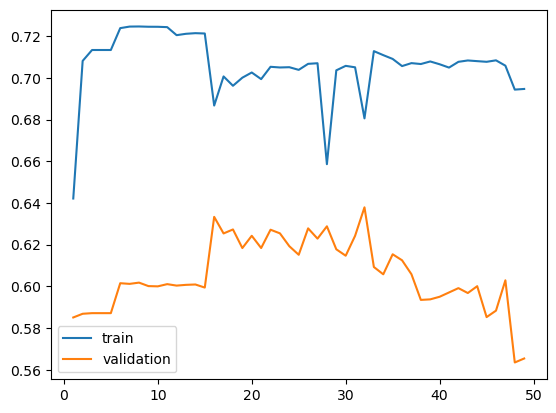

In [316]:
# Step 6: Plot the AUC scores
k_values = range(1, max_features + 1)
plt.plot(k_values, train_auc_scores, label = 'train')
plt.plot(k_values, validation_auc_scores, label = 'validation')
plt.legend()

In [317]:
# Select features
best_k = np.argmax(validation_auc_scores) + 1
selector = SelectKBest(score_func=f_classif, k=best_k)
selector.fit(X_train_scaled, training_y)
best_k

c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


np.int64(32)

In [318]:


# Get the boolean mask of selected features for k=?
selected_features = training_x.columns[selector.get_support()]

# Get the feature importance scores for k=?
feature_scores = selector.scores_

# Combine feature names and their scores into a DataFrame for easier visualization
feature_importance = pd.DataFrame({
    'Feature': training_x.columns,
    'Score': feature_scores
})

# Sort the features by their score in descending order
feature_importance.sort_values('Score', ascending=False)


,Feature,Score
0,gender,252.216545
29,age,222.041179
42,province__missing,93.288015
48,language__missing,93.288015
45,region__missing,93.288015
7,max_donated,77.548695
9,donated_last_year,48.323241
5,donated_ins_camp,47.701852
1,total_donated,45.284826
27,ratio_amount,45.284826


## Prediction

In [319]:
selected = list(feature_importance.sort_values('Score', ascending=False).iloc[:18]['Feature'])

In [320]:
model = LogisticRegression(solver = "lbfgs", max_iter = 800, class_weight = 'balanced')
model.fit(training_x[selected], training_y)

c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 800 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=800).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,800
,multi_class,'deprecated'


In [321]:
training_x["predicted_churn"] = model.predict(training_x[selected])
validation_x["predicted_churn"] = model.predict(validation_x[selected])

In [322]:
training_x

,gender,total_donated,num_donations,donated_outs_camp,num_outs_camp,donated_ins_camp,num_ins_camp,max_donated,last_time_donated(days),donated_last_year,...,province__Walloon Brabant,province__West Flanders,province__missing,region__Flanders,region__Wallonia,region__missing,language__FR,language__NL,language__missing,predicted_churn
donorID,,,,,,,,,,,,,,,,,,,,,
D100001,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,True,False,1.0
D100002,0,20.0,1.0,0.0,0.0,20.0,1.0,20.0,1333.0,0.0,...,False,False,False,True,False,False,False,True,False,0.0
D100004,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,1.0
D100008,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,True,False,False,1.0
D100009,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D144686,1,50.0,1.0,0.0,0.0,50.0,1.0,50.0,1225.0,0.0,...,False,False,False,True,False,False,False,True,False,1.0
D144687,0,10.0,1.0,0.0,0.0,10.0,1.0,10.0,1033.0,0.0,...,False,False,False,False,True,False,True,False,False,0.0
D144689,0,100.0,1.0,0.0,0.0,100.0,1.0,100.0,71.0,100.0,...,False,False,False,True,False,False,False,True,False,1.0


In [323]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(accuracy_score(training_y ,training_x['predicted_churn'])*100)
print(accuracy_score(validation_y,validation_x['predicted_churn'])*100)

66.18321485897731
65.49034899590563


In [324]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.8,
    eval_metric='auc'
)

model.fit(training_x[selected], training_y)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [325]:
from sklearn.metrics import roc_auc_score

pred = model.predict_proba(validation_x[selected])[:,1]
roc_auc_score(validation_y, pred)


0.6246702582156808

# I will use this later

### a) demographic

#### age_group

In [ ]:
# Computing the age group
basetable = training
def age_group(age):
    if age <= 14:
        return 'Children'
    elif age <= 24:
        return 'Youth'
    elif age <= 64:
        return 'Adults'
    else:
        return 'Seniors'

basetable['age_group'] = basetable['age'].apply(age_group)

### b) timing (RFM + LOR)

In [ ]:
# Get past gift behavior
past_gifts = gifts.copy()
campaign_date = rd1
past_gifts_6169 = past_gifts[past_gifts['gift_date'] < campaign_date]

In [ ]:
# Aggregate features by donorID
timing_6169 = past_gifts_6169.groupby('donorID').agg({
    'gift_date': ['max', 'min'],  # To calculate Recency and Length of Relationship
    'amount': ['count', 'sum', 'mean', 'max', 'min'] # Frequency and Monetary
})

# Adding a suffix
timing_6169.columns = ['_'.join(col).strip() for col in timing_6169.columns.values]
timing_6169.reset_index(inplace=True)

# Calculating Recency (Days since last gift to campaign date)
timing_6169['recency'] = (rd1 - timing_6169['gift_date_max']).dt.days

# Renaming columns for clarity
timing_6169.rename(columns={
    'amount_count': 'frequency',
    'amount_sum': 'total_amount',
    'amount_mean': 'avg_amount',
    'amount_max': 'max_amount'
}, inplace=True)

timing_6169.head(2)

,donorID,gift_date_max,gift_date_min,frequency,total_amount,avg_amount,max_amount,amount_min,recency
0,D100001,2011-12-30,2004-03-23,12,178.0,14.833333,30.0,6.6,2440
1,D100002,2015-01-10,2015-01-10,1,20.0,20.000000,20.0,20.0,1333


In [ ]:
# Adding the length of relationship (LOR)
timing_6169['LOR'] = timing_6169['gift_date_max'] - timing_6169['gift_date_min']

### c) campaign-specific

In [ ]:
# We need this to get 'CostUnit' associated with each gift, therefore, we will temporarily merge gifts and campaign data to get it
# Indeed, gift is the only table that can link our basetable with campaign, since it has the campaignID key
gifts_with_costs = pd.merge(gifts, camp, on='campaignID', how='left')

In [ ]:
# Looking at behavior before the campaign we are predicting
history_campaigns = gifts_with_costs[gifts_with_costs['gift_date'] < rd1]

In [ ]:
# Get a donor-level granularity
campaign_features = history_campaigns.groupby('donorID').agg({
    'CostUnit': ['mean', 'min', 'max'],  # How expensive are the campaigns they support? (get an idea of their relative importance)
    'lettersSent': ['mean']   # What is the importance of the campaign they support
})

In [ ]:
# To get more consistent column names
campaign_features.columns = ['_'.join(col).strip() for col in campaign_features.columns.values]
campaign_features.reset_index(inplace=True)

In [ ]:
# Adding the cost per unit range
campaign_features['cost_range'] = campaign_features['CostUnit_max'] - campaign_features['CostUnit_min']
campaign_features.head()

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,cost_range
0,D100001,NaN,NaN,NaN,NaN,NaN
1,D100002,NaN,NaN,NaN,NaN,NaN
2,D100003,NaN,NaN,NaN,NaN,NaN
3,D100004,NaN,NaN,NaN,NaN,NaN
4,D100005,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Merging with camp database to add some campaign-level information
basetable = pd.merge(basetable, campaign_features, on='donorID', how='left')
basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   donorID                    34888 non-null  object 
 1   gender                     34888 non-null  int64  
 2   total_donated              34888 non-null  float64
 3   num_donations              34888 non-null  float64
 4   donated_outs_camp          34888 non-null  float64
 5   num_outs_camp              34888 non-null  float64
 6   donated_ins_camp           34888 non-null  float64
 7   num_ins_camp               34888 non-null  float64
 8   max_donated                34888 non-null  float64
 9   last_time_donated(days)    34888 non-null  float64
 10  age                        34888 non-null  int64  
 11  never_donated              34888 non-null  int64  
 12  province__Antwerp          34888 non-null  bool   
 13  province__Brussels         34888 non-null  boo

## IV/ Data cleaning

### 1) Cleaning columns

In [ ]:
# Setting donorID to index
basetable = basetable.set_index('donorID') # Since we do not need it in the model but it still interesting to be reachable

### 2) Missing values

In [ ]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(basetable.isna().sum())
print('---------------------------------')
print(f'The data shows {basetable.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
gender                           0
total_donated                    0
num_donations                    0
donated_outs_camp                0
num_outs_camp                    0
donated_ins_camp                 0
num_ins_camp                     0
max_donated                      0
last_time_donated(days)          0
age                              0
never_donated                    0
province__Antwerp                0
province__Brussels               0
province__East Flanders          0
province__Flemish Brabant        0
province__Hainaut                0
province__Liege                  0
province__Limburg                0
province__Luxembourg             0
province__Namur                  0
province__Walloon Brabant        0
province__West Flanders          0
province__missing                0
region__Flanders                 0
region__Wallonia                 0
region__missing                  0
language__FR                 

In [ ]:
# language by the mode as well
language_mode = basetable['language'].mode()[0]
basetable['language'] = basetable['language'].fillna(value=language_mode)

KeyError: 'language'

In [ ]:
# Inputing by 0 for the others (they likely represent the same clients as well because they are the same number and ad interconnected)
cols = ['gift_date_max', 'gift_date_min', 'frequency', 'total_amount', 'avg_amount', 'max_amount', 'amount_min', 'recency',
        'LOR', 'CostUnit_mean', 'CostUnit_min', 'CostUnit_max', 'lettersSent_mean', 'cost_range']

for col in cols:
        basetable[col] = basetable[col].fillna(value=0)

print(f'There are {basetable.isna().sum().sum()} missing values in the basetable at this stage.')

There are 0 missing values in the basetable at this stage.


### 3) Outliers

In [ ]:
# Finding outliers (using only the numerical columns)
num_cols = basetable.select_dtypes(include=['float', 'int']).columns

In [ ]:
print(num_cols)

Index(['target', 'age', 'region_Flanders', 'region_Wallonia',
       'province_Antwerp', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'frequency',
       'total_amount', 'avg_amount', 'max_amount', 'amount_min', 'recency',
       'CostUnit_mean', 'CostUnit_min', 'CostUnit_max', 'lettersSent_mean',
       'cost_range'],
      dtype='object')


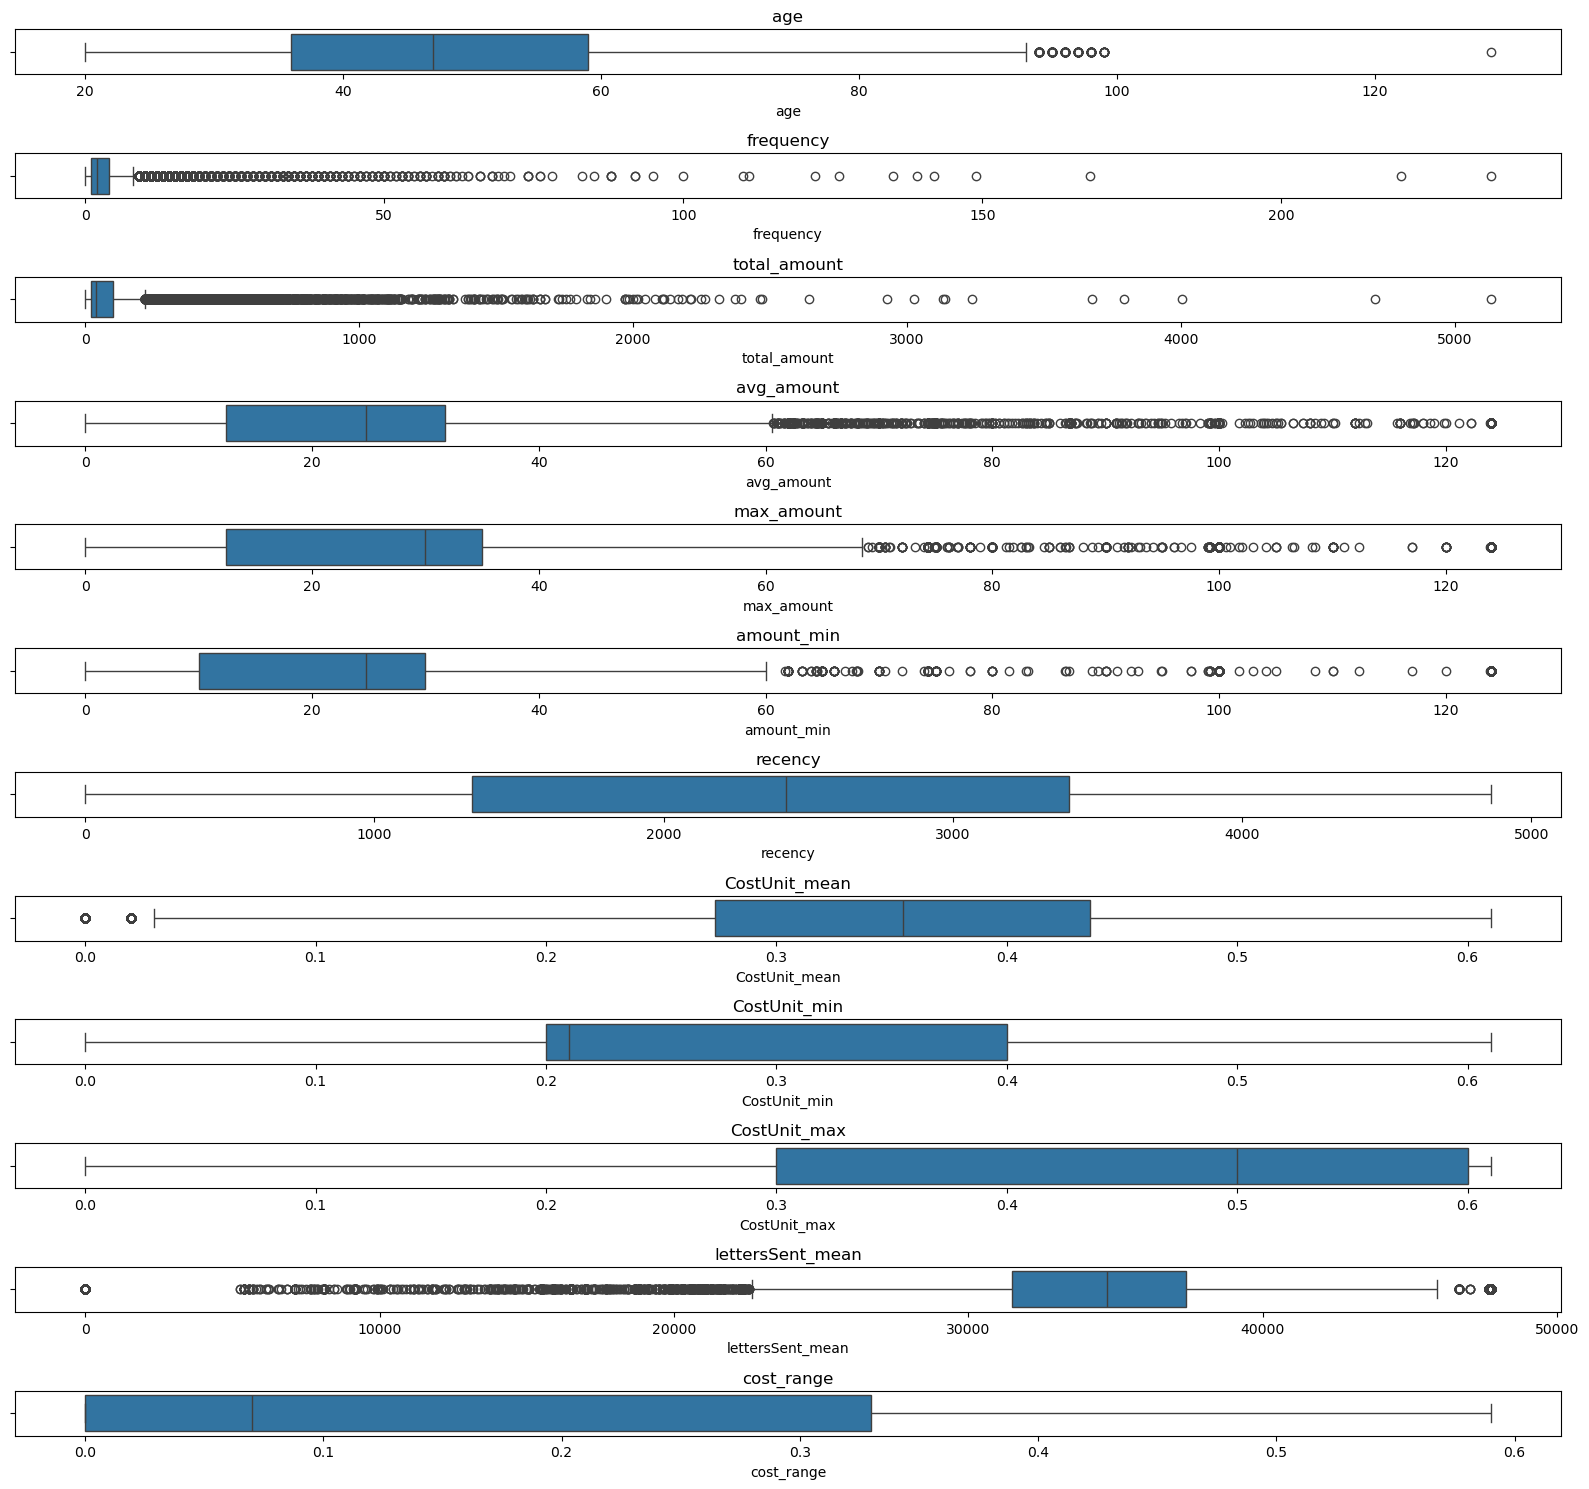

In [ ]:
# Verifying outliers
cols = ['age','frequency',
       'total_amount', 'avg_amount', 'max_amount', 'amount_min', 'recency',
       'CostUnit_mean', 'CostUnit_min', 'CostUnit_max', 'lettersSent_mean',
       'cost_range']

fig, ax = plt.subplots(nrows=len(cols), ncols=1, figsize=(16, 15))

for i, col in enumerate(cols):
    sns.boxplot(ax=ax[i], x=basetable[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
# Winsorizing the results
lower = basetable[cols].quantile(0.01)
upper = basetable[cols].quantile(0.99)

# printing the results
print(lower)
print(upper)

age                 24.0
frequency            0.0
total_amount         0.0
avg_amount           0.0
max_amount           0.0
amount_min           0.0
recency              0.0
CostUnit_mean        0.0
CostUnit_min         0.0
CostUnit_max         0.0
lettersSent_mean     0.0
cost_range           0.0
Name: 0.01, dtype: Float64
age                     90.0
frequency               30.0
total_amount         861.036
avg_amount             100.0
max_amount            123.95
amount_min             99.16
recency               4626.0
CostUnit_mean            0.6
CostUnit_min             0.6
CostUnit_max            0.61
lettersSent_mean    47746.96
cost_range              0.57
Name: 0.99, dtype: Float64


In [ ]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
basetable = basetable.copy()
basetable[cols] = basetable[cols].clip(lower=lower, upper=upper, axis=1)